# ベイズ脳仮説と神経活動による不確実性の表現

## ベイズ脳仮説

{cite:p}`Shimazaki2019-yx`, {cite:p}`Shimazaki2020-kx`,

## 神経活動による不確実性の表現
ここまでは最尤推定やMAP推定などにより，パラメータ(神経活動，シナプス結合)の点推定を行ってきた．**不確実性(uncertainty)** を神経回路で表現する方法として主に2つの符号化方法，**サンプリングに基づく符号化(sampling-based coding; SBC or neural sampling model)** および**確率的集団符号化(probabilistic population coding; PPC)** が提案されている．SBCは神経活動が元の確率分布のサンプルを表現しており，時間的に多数の活動を集めることで元の分布の情報が得られるというモデルである．PPCは神経細胞集団により，確率分布を表現するというモデルである．

```{note}
sampling-based codingの訳は良い訳が思いつかないので案があればコメントをいただきたく存じます．
```

Neural sampling

bayesian brain without probability {cite:p}`Sanborn2016-en`


neural sampling

*ToDo:*
- (Walker et al., 2022)がまとめ．
- (Fiser et al., 2010)の比較表を入れる．
- 神経活動の変動性 (neural variability)
- 自発活動が事前分布であるという説 {cite:p}`Fiser2010-kw`, {cite:p}`Berkes2011-it`.
- {cite:p}`Hoyer2002-ci`

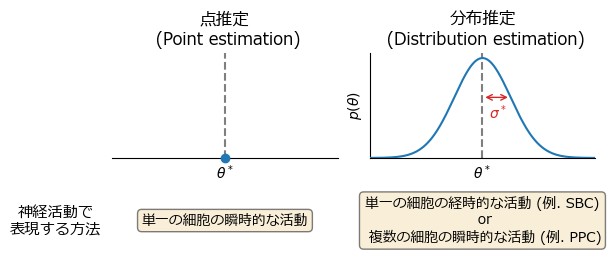

In [4]:
using PyPlot, LinearAlgebra, Random, Distributions
using PyPlot: matplotlib
using KernelDensity
Random.seed!(2)
rc("font", family="Meiryo")

gaussian(x, μ, σ) = 1/(σ*sqrt(2*π))*exp(-0.5*((x-μ)/σ)^2)

x = -4:0.01:4
d = Normal(0, 1); 

props = Dict("boxstyle" => "round", "facecolor" => "wheat", "alpha" => 0.5)
fig, ax = subplots(1,2, figsize=(6,2),sharex="all",sharey="all",constrained_layout=true)
ax[1].set_title("点推定\n (Point estimation)")
ax[2].set_title("分布推定\n (Distribution estimation)")
ax[2].set_ylabel(L"$p(\theta)$")
ax[1].scatter(0, 0,clip_on=false,zorder=5)
ax[2].plot(x, pdf.(d, x), zorder=5)
ax[1].spines.left.set_visible(false)
for i in 1:2
    ax[i].set_xlabel(L"$\theta^*$")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylim(0, )
    ax[i].set_xlim(-4,4)
    ax[i].axvline(0, linestyle="dashed", color="tab:gray")
    ax[i].spines.right.set_visible(false)
    ax[i].spines.top.set_visible(false)
end

ax[2].annotate(text="", xy=(0,pdf(d, 1)), xytext=(1,pdf(d, 1)), arrowprops=Dict("arrowstyle" => "<->", "color" => "tab:red"))
ax[2].text(0.55, pdf(d, 1)-0.06, L"$\sigma^*$",ha="center",va="center",color="tab:red");

ax[1].text(-6, -0.25, "神経活動で\n表現する方法",fontsize=11,ha="center",va="center");
ax[1].text(0, -0.25, "単一の細胞の瞬時的な活動",fontsize=10,ha="center",va="center", bbox=props);
ax[2].text(0, -0.25, "単一の細胞の経時的な活動 (例. SBC)\n or\n 複数の細胞の瞬時的な活動 (例. PPC)",fontsize=10,ha="center",va="center", bbox=props);

In [ ]:
Ns = 20 # num. sampling
Np = 10 # num. ppc neurons

μ_dist = -0.5
mixed_gauss = Normal(μ_dist, 0.5) #混合分布
y = pdf.(mixed_gauss, x); # 真の確率密度
samples = rand(mixed_gauss, Ns); # サンプリング
U = kde(samples); # サンプリングのkde

μs = range(-2, 2, length=Np)
tuning_curves = hcat([gaussian.(x, μ, 0.5) for μ in μs]...)';

ppc_fr = exp.(-(μs .- μ_dist).^2/0.5);
act = ppc_fr' * tuning_curves;

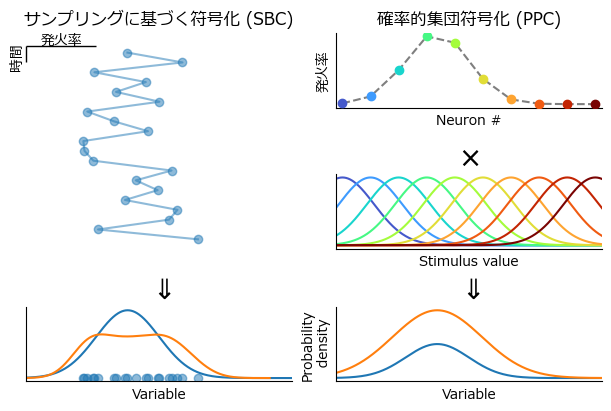

In [6]:
mosaic = """
DA
DB
EC
"""

fig, ax = plt.subplot_mosaic(mosaic,figsize=(6, 4),constrained_layout=true)
cm = get_cmap(:turbo) # get color map
ax["D"].set_title("サンプリングに基づく符号化 (SBC)")
ax["D"].plot(samples, 1:Ns, "o-", alpha=0.5)
ax["D"].set_ylim(-1,)
ax["D"].invert_yaxis()
ax["D"].text(-1.55, -0.3, "発火率", ha="center",va="center"); 
ax["D"].text(-2.25, 1.375, "時間", ha="center",va="center",rotation="vertical")
ax["D"].hlines(y=0.3, xmin=-2.1, xmax=-1.0, clip_on=false, color="k", linewidths=1)
ax["D"].vlines(x=-2.1, ymin=0.3, ymax=2.0, clip_on=false, color="k", linewidths=1)
ax["D"].xaxis.tick_top()
ax["D"].xaxis.set_label_position("top") 
ax["D"].axis("off")

ax["E"].set_title(L"$\Downarrow$", fontsize=20)
ax["E"].plot(x, y)
ax["E"].plot(U.x, U.density)
ax["E"].scatter(samples, zeros(Ns), alpha=0.5, marker="o")
ax["E"].spines.right.set_visible(false)
ax["E"].spines.top.set_visible(false)
ax["E"].set_xlabel("Variable")
ax["E"].set_ylabel("確率密度");

ax["A"].set_title("確率的集団符号化 (PPC)")

for i in 1:Np
    ax["A"].scatter(μs[i], ppc_fr[i],color=cm(i/Np),zorder=5)
end
ax["A"].plot(μs, ppc_fr, "--", color="tab:gray")
ax["A"].set_ylabel("発火率"); 
ax["A"].set_xlabel("Neuron #")
for i in 1:Np
    ax["B"].plot(x, tuning_curves[i, :],color=cm(i/Np))
end

ax["B"].set_title(L"$\times$", fontsize=20)
ax["B"].set_xlabel("Stimulus value")

ax["C"].set_title(L"$\Downarrow$", fontsize=20)
ax["C"].plot(x, y)
ax["C"].plot(x, act)
ax["C"].set_xlabel("Variable")
for i in 'A':'C'
    ax[string(i)].spines.right.set_visible(false)
    ax[string(i)].spines.top.set_visible(false)
end

for i in 'A':'E'
    ax[string(i)].set_xlim(-2.1, 2.1)
    ax[string(i)].set_xticks([])
    ax[string(i)].set_yticks([])
end

#fig.tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```